##문자를 읽을 수 있는 딥러닝

개발 환경
<br/>데이터 정보
<br/>OCR 서비스 구상
<br/>Keras OCR
<br/>Tesseract

OCR 서비스 구현
<br/>서비스 작동 원리

사용자 시뮬레이션
<br/>파일 초기화
<br/>데이터프레임 초기화
<br/>도서 사진 파일 업로드
<br/>OCR. 웹 크롤링
<br/>클립보드로 메모장에 저장

결론
<br/>참고문헌

# 개발 환경

In [ ]:
!pip install keras-ocr

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
!pip install --ignore-installed Pillow==9.0.0

pytesseract.image_to_string 사용 시에
<br/>AttributeError: module 'PIL.Image' has no attribute 'Resampling'가 발생하므로
<br/>Pillow==9.0.0 버전을 설치하고
<br/>Restart Runtime한다.

In [2]:
import sys
import os
import cv2
import keras_ocr
import pytesseract
from pytesseract import image_to_string
from PIL import Image

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
from google.colab import files

In [ ]:
from selenium import webdriver
from urllib.request import urlopen
from urllib.parse import quote_plus
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['keras-ocr=', 'pytesseract=', 'pandas=', 'matplotlib=', 'opencv-python',
                 'selenium=', 'webdriver', 'urllib', 'clipboard', 'image', 'Pillow']
library_version = []
count = 0

import sys
print(sys.version)
print()

with open('/content/drive/MyDrive/lms/library_version.txt', 'r') as f:
    lines = f.read().splitlines() 

for i in range(len(lines)):
  for line in lines[i:i+1]:
    for library in library_name:
      if library in line:
        library_version.append(line)
        count += 1
        print(line, end = '    ')
        if count % 3 == 0:
          print()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

imageio==2.9.0    imagesize==1.4.1    keras-ocr==0.9.1    
matplotlib==3.2.2    opencv-python==4.6.0.66    opencv-python-headless==4.6.0.66    
pandas==1.3.5    Pillow==9.2.0    pytesseract==0.3.9    
scikit-image==0.18.3    selenium==4.3.0    sklearn-pandas==1.8.0    
urllib3==1.26.11    

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보


영어 원서 표지 사진 3장이다.

이렇게 데이터를 선정한 이유는
<br/>Keras OCR, Tesseract는 영어에서 성능이 뛰어난 편이며
<br/>한국어에서는 제대로 인식하지 못하기 때문이다.

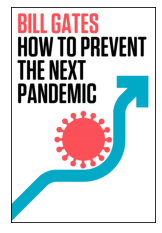

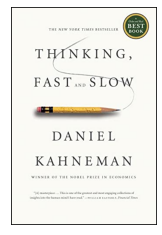

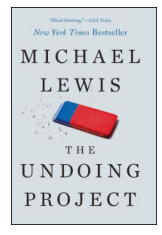

In [15]:
image_path = [
  '/content/drive/MyDrive/lms/ocr/book1.jpg',
  '/content/drive/MyDrive/lms/ocr/book2.jpg',
  '/content/drive/MyDrive/lms/ocr/book3.jpg'
]

rows = 5
cols = 2
fig = plt.figure(figsize=(20, 23))
for idx, path in enumerate(image_path, 1):
    ax = fig.add_subplot(rows, cols, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()

#Keras OCR

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 recognize에 이미지를 넣는다.

In [ ]:
images = [ keras_ocr.tools.read(path) for path in image_path]
prediction_groups = [pipeline.recognize([path]) for path in image_path]

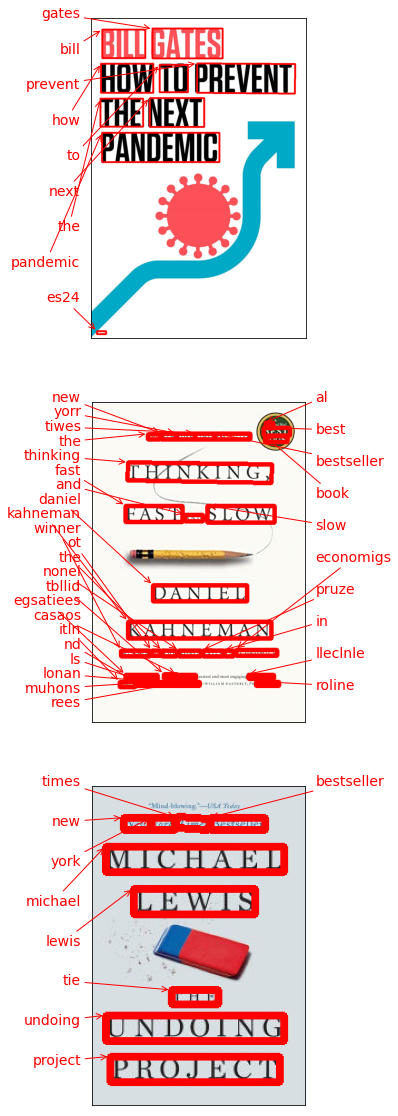

In [ ]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

#Tesseract

In [ ]:
image = cv2.imread(image_path[0])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rgb_image = np.asarray(rgb_image)
text1 = pytesseract.image_to_string(rgb_image, lang='eng')
text1 = re.sub(r"\s+", " ", text1)
print(text1)

BILL GATES HOW TO PREVENT THE NEXT PANDEMIC = 


In [ ]:
image = cv2.imread(image_path[1])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
text2 = pytesseract.image_to_string(rgb_image, lang='eng')
text2 = re.sub(r"\s+", " ", text2)
print(text2)

THINKING, FAST SLOW We DANIEL KAHNEMAN 


In [ ]:
image = cv2.imread(image_path[2])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
text3 = pytesseract.image_to_string(rgb_image, lang='eng')
text3 = re.sub(r"\s+", " ", text3)
print(text3)

 MICHAEL LEWIS & THE UNDOING PROJECT 


#OCR 서비스 구상

**OCR 도서 정보 검색 서비스**

Tesseract으로 OCR, Selenium으로 웹크롤링을 한다.

사진 속의 책 제목을 인식하여 인터넷 도서 정보를 검색한다.

스마트폰 카메라로 촬영을 하면 인식한 책 제목에 대한 도서 정보를 웹 크롤링하여 클립보드로 복사하는 기능이 있다.
<br/>도서관, 서점, 북카페, 책방에서 마음에 드는 책의 정보를 메모하고 싶을 때 유용하다.

1) OCR로 이미지 속의 책 제목 텍스트를 추출한다.
<br/>2) 책 제목을 [네이버 책 사이트](https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query=)에서 검색한다.
<br/>3) CSS Selector를 이용하여 도서 정보를 수집한다.
<br/>4) 클립보드 형식으로 도서 정보를 복사한다.

<br/>[김은령, '(단독) 네이버 도서검색 2주째 중단…"하루 판매 200권→1권" 날벼락', 머니투데이, 2022.07.20](https://news.mt.co.kr/mtview.php?no=2022072015321999301)

네이버 도서 검색서비스 개편으로 인해 웹 크롤링 코드를 수정할 예정이다.
<br/>2022년 7월 20일 네이버가 도서 검색서비스 '네이버 책'과 네이버쇼핑 '도서' 카테고리를 개편하면서
<br/>네이버 통합검색에서 책, 도서 쇼핑 검색이 중단됐다.
<br/>2022년 7-8월 기준 네이버쇼핑 도서 카테고리와 네이버책 서비스를 통합해 '도서전문검색서비스'로 개편해 오픈할 예정이다.

#OCR 서비스 구현

##서비스 작동 원리

In [ ]:
uploaded = files.upload() 

for fn in uploaded.keys(): 
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving book1.jpg to book1.jpg
User uploaded file "book1.jpg" with length 95751 bytes


In [ ]:
ls -al

total 120
drwxr-xr-x 1 root root  4096 Aug  9 08:18 ./
drwxr-xr-x 1 root root  4096 Aug  9 05:06 ../
-rw-r--r-- 1 root root 95751 Aug  9 08:18 book1.jpg
drwxr-xr-x 4 root root  4096 Aug  3 20:20 .config/
-rw-r--r-- 1 root root    30 Aug  9 06:43 directory.txt
drwx------ 5 root root  4096 Aug  9 05:12 drive/
drwxr-xr-x 1 root root  4096 Aug  3 20:21 sample_data/


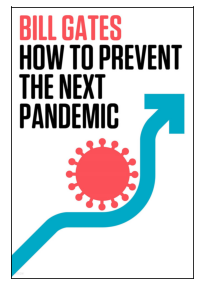

In [ ]:
c = imread('book1.jpg')
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(c)
plt.show()

In [ ]:
image = cv2.imread('book1.jpg')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rgb_image = np.asarray(rgb_image)
text1 = pytesseract.image_to_string(rgb_image, lang='eng')
text1 = re.sub(r"\s+", " ", text1)
print(text1)

BILL GATES HOW TO PREVENT THE NEXT PANDEMIC = 


In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')       
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=options)

In [ ]:
url = 'https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query='
kword = text1
base_url = url + quote_plus(kword)
base_url

'https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query=BILL+GATES+HOW+TO+PREVENT+THE+NEXT+PANDEMIC+%3D+'

In [ ]:
driver.get(base_url)
book_info = driver.find_element(By.CSS_SELECTOR,'#searchBiblioList > li:nth-child(1) > dl')

In [ ]:
print(book_info.text)

How to Prevent the Next Pandemic (빌 게이츠 신간)
Gates, Bill 저 | KnopfPublishingGroup | 2022.05.03
0
| 네티즌리뷰 0건 |  33,500원 → 20,770원(-38%)
소개  HAPPENS NEXT. HOW CAN WE PREVENT A NEW PANDEMIC FROM KILLING MILLIONS OF PEOPLE AND DEVASTATING THE GLOBAL ECONOMY? CAN WE EVEN HOPE TO ACCOMPLISH THIS? BILL GATES BELIEVES THE ANSWER IS YES, AND IN THIS BOOK HE LAYS OUT CLEARLY AND CONVINCINGLY WHAT THE WORLD...


In [ ]:
first_book_info = book_info.text.split('\n')

if first_book_info[2] == '별점':
  first_book_info[2] = first_book_info[3]
  first_book_info[3] = first_book_info[4]
  first_book_info[4] = first_book_info[5]
  del first_book_info[5]

author_translator_publisher_date = first_book_info[1].split('|')
review_price = first_book_info[3].split('|')
first_book_info.extend(author_translator_publisher_date)
first_book_info.extend(review_price)
del first_book_info[1], first_book_info[2]

if '역' not in first_book_info[4]:
  first_book_info[6] = first_book_info[5]
  first_book_info[5] = first_book_info[4]
  first_book_info[4] = ''

if first_book_info[7] == '':
  first_book_info[7] = first_book_info[8]
  first_book_info[8] = first_book_info[9]
  del first_book_info[9]

first_book_info = pd.DataFrame(first_book_info).transpose()
      
first_book_info = first_book_info.reset_index()
del first_book_info['index']
first_book_info.columns = ['Title', 'Rating', 'Introduction', 'Author', 'Transloator', 'Publisher', 'Date', 'Reivew', 'Price']
first_book_info = first_book_info[['Title', 'Author', 'Transloator', 'Publisher', 'Date', 'Rating', 'Reivew', 'Price', 'Introduction']]

first_book_info['Author'] = first_book_info['Author'].map(lambda x: x.rstrip(' 저'))
first_book_info['Transloator'] = first_book_info['Transloator'].map(lambda x: x.rstrip(' 역'))
first_book_info['Introduction'] = first_book_info['Introduction'].map(lambda x: x.lstrip('소개').title())
first_book_info['Reivew'] = first_book_info['Reivew'].map(lambda x: x.lstrip('네티즌리뷰 ').rstrip(' 건'))
    

first_book_info

,Title,Author,Transloator,Publisher,Date,Rating,Reivew,Price,Introduction
0,How to Prevent the Next Pandemic (빌 게이츠 신간),"Gates, Bill",,KnopfPublishingGroup,2022.05.03,0,0,"33,500원 → 20,770원(-38%)",Happens Next. How Can We Prevent A New Pande...


##사용자 시뮬레이션

###파일 초기화

In [ ]:
rm *.jpg

In [ ]:
ls

directory.txt  drive/  sample_data/


###데이터프레임 초기화

In [ ]:
first_book_info = pd.DataFrame(index=range(0, 1), columns = {'0'})

In [ ]:
first_book_info 

,0
0,NaN


###파일 업로드

In [ ]:
uploaded = files.upload() 

for fn in uploaded.keys(): 
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving book1.jpg to book1.jpg
Saving book2.jpg to book2.jpg
Saving book3.jpg to book3.jpg
User uploaded file "book1.jpg" with length 95751 bytes
User uploaded file "book2.jpg" with length 16342 bytes
User uploaded file "book3.jpg" with length 10419 bytes


In [ ]:
ls *.jpg  > directory.txt



###OCR. 웹 크롤링

In [ ]:
def OCR_Service(txt, first_book_info):
    
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')       
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver', options=options)

    f = open(txt, "r")
    lst = []
    while True:
      line = f.readline().strip()
      if not line: break
      lst.append(line)

    for jpg in lst:
      image = cv2.imread(jpg)
      rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      rgb_image = np.asarray(rgb_image)
      text = pytesseract.image_to_string(rgb_image, lang='eng')
      text = re.sub(r"\s+", " ", text)
    
      url = 'https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query='
      kword = text
      base_url = url + quote_plus(kword)
    
      driver.get(base_url)
    
      book_info = driver.find_element(By.CSS_SELECTOR, '#searchBiblioList > li:nth-child(1) > dl')
    
      new_book_info = book_info.text.split('\n')

      if new_book_info[2] == '별점':
        new_book_info[2] = new_book_info[3]
        new_book_info[3] = new_book_info[4]
        new_book_info[4] = new_book_info[5]
        del new_book_info[5]

      author_translator_publisher_date = new_book_info[1].split('|')
      review_price = new_book_info[3].split('|')
      new_book_info.extend(author_translator_publisher_date)
      new_book_info.extend(review_price)
      del new_book_info[1], new_book_info[2]

      if '역' not in new_book_info[4]:
        new_book_info[6] = new_book_info[5]
        new_book_info[5] = new_book_info[4]
        new_book_info[4] = ''

      if new_book_info[7] == '':
        new_book_info[7] = new_book_info[8]
        new_book_info[8] = new_book_info[9]
        del new_book_info[9]

      new_book_info = pd.DataFrame(new_book_info).transpose()
      
      first_book_info = first_book_info.append(new_book_info)

    first_book_info = first_book_info.iloc[1:, :-1].reset_index()
    del first_book_info['index']
    first_book_info.columns = ['Title', 'Rating', 'Introduction', 'Author', 'Transloator', 'Publisher', 'Date', 'Reivew', 'Price']
    first_book_info = first_book_info[['Title', 'Author', 'Transloator', 'Publisher', 'Date', 'Rating', 'Reivew', 'Price', 'Introduction']]

    first_book_info['Author'] = first_book_info['Author'].map(lambda x: x.rstrip(' 저'))
    first_book_info['Transloator'] = first_book_info['Transloator'].map(lambda x: x.rstrip(' 역'))
    first_book_info['Introduction'] = first_book_info['Introduction'].map(lambda x: x.lstrip('소개').title())
    first_book_info['Reivew'] = first_book_info['Reivew'].map(lambda x: x.lstrip('네티즌리뷰 ').rstrip(' 건'))

    return first_book_info

In [ ]:
book_info_memo = OCR_Service('directory.txt', first_book_info)

In [ ]:
book_info_memo

,Title,Author,Transloator,Publisher,Date,Rating,Reivew,Price,Introduction
0,How to Prevent the Next Pandemic (빌 게이츠 신간),"Gates, Bill",,KnopfPublishingGroup,2022.05.03,0,0,"33,500원 → 20,770원(-38%)",Happens Next. How Can We Prevent A New Pande...
1,"Thinking, Fast and Slow (Paperback) (생각에 관한 생각)",대니얼 카너먼(심리학자),,Penguin,2012.05.10,10,6,"18,000원 → 14,940원(-17%)",The Answer Lies In The Two Ways We Make Choi...
2,The Undoing Project A Friendship that Changed ...,Michael Lewis,,PenguinBooksLtd,2016.12.06,0,0,NaN,Engages Both Heart And Brain Like No Other' ...


###클립보드로 메모장에 저장

In [ ]:
book_info_memo.to_clipboard 

#결론

Keras OCR과 Tesseract은 글씨체가 다른 텍스트, 영어가 아닌 다른 언어 텍스트를 인식하지 못한다.
<br/>성능이 뛰어난 Google Vision API 사용의 필요성을 느낀다.

네이버 도서 검색서비스 개편으로 인해 웹 크롤링 코드를 수정할 예정이다.
<br/>2022년 7월 20일 네이버가 도서 검색서비스 '네이버 책'과 네이버쇼핑 '도서' 카테고리를 개편하면서
<br/>네이버 통합검색에서 책, 도서 쇼핑 검색이 중단됐다.
<br/>2022년 7-8월 기준 네이버쇼핑 도서 카테고리와 네이버책 서비스를 통합해 '도서전문검색서비스'로 개편해 오픈할 예정이다.



#참고문헌

**LMS**
<br/>[wer2774](https://github.com/Sangkwun)

<br/>**기사**
<br/>[김은령, '(단독) 네이버 도서검색 2주째 중단…"하루 판매 200권→1권" 날벼락', 머니투데이, 2022.07.20](https://news.mt.co.kr/mtview.php?no=2022072015321999301)

<br/>**웹사이트**
<br/>[네이버 책](https://book.naver.com/search/search.naver?sm=sta_hty.book&sug=&where=nexearch&query=)
<br/>[Module PIL has not attribute "Resampling"](https://stackoverflow.com/questions/71738218/module-pil-has-not-attribute-resampling)
<br/>[파이썬 Tesseract OCR 활용 (기본) - Python](https://yunwoong.tistory.com/58?category=902345)
<br/>[colab에서 selenium 사용하는 법](https://ai-run.tistory.com/47)
<br/>[셀레니움(selenium) 사용법: 설치부터 네이버 자동 로그인까지](https://itholic.github.io/python-selenium-tutorial/)